# `HFSModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `HFSModel` model. The `HFSModel` models the hyperfine spectral structure of an arbitrary molecule in order to predict the physical conditions of the emitting gas. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

from bayes_cn_hfs import HFSModel

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+0.g50000b9.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])

dict_keys(['freq', 'Aul', 'degu', 'Eu', 'relative_int', 'log10_Q_terms'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]


## Simulating Data

To test the model, we must simulate some data. We can do this with `HFSModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"observation"`.

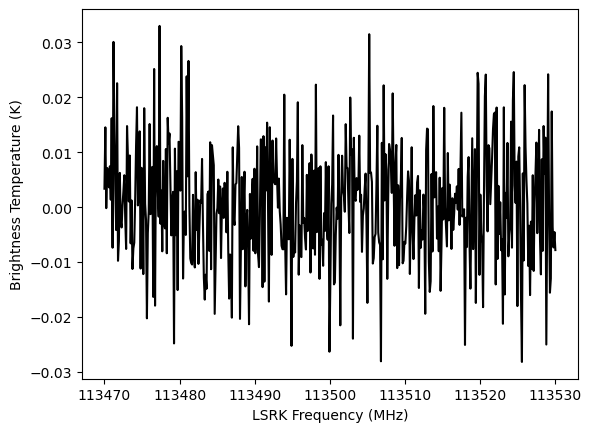

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.linspace(113470.0, 113530.0, 500) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.01 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

Dropping the un-observed transitions at the following frequencies (MHz):
[113123.3687 113144.19   113170.535  113191.325 ]


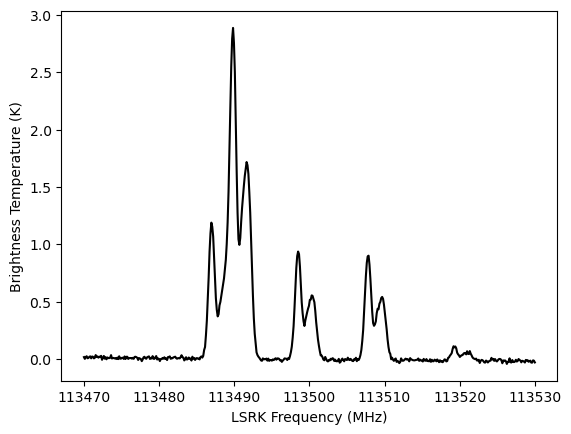

In [4]:
from bayes_cn_hfs import HFSModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = HFSModel(
    dummy_data,
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 1.0], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized polynomial baseline coeffs
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "log10_N": [14.0, 13.5, 14.2],
    "log10_tex": [1.0, 1.2, 1.1],
    "fwhm": [3.0, 2.0, 2.5],
    "velocity": [-2.0, 0.0, 3.0],
    "baseline_observation_norm": [-0.5, -3.0, 2.0], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `HFSModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = HFSModel(
    data,
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 1.0], # mean and width of log10(N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(Tex) prior (K)
    prior_fwhm = 1.0, # width of FWHM prior (km/s)
    prior_velocity = [0.0, 10.0], # mean and width of velocity prior (km/s)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized polynomial baseline coeffs
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Dropping the un-observed transitions at the following frequencies (MHz):
[113123.3687 113144.19   113170.535  113191.325 ]


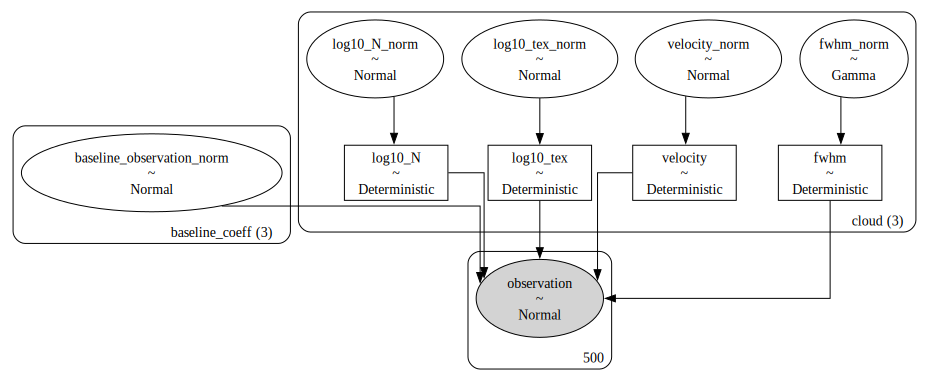

In [7]:
# Plot model graph
model.graph().render('hfs_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
             log10_N_norm ~ Normal(0, 1)
           log10_tex_norm ~ Normal(0, 1)
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
                  log10_N ~ Deterministic(f(log10_N_norm))
                log10_tex ~ Deterministic(f(log10_tex_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
              observation ~ Normal(f(baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_norm, log10_N_norm, log10_tex_norm, observation, velocity_norm]


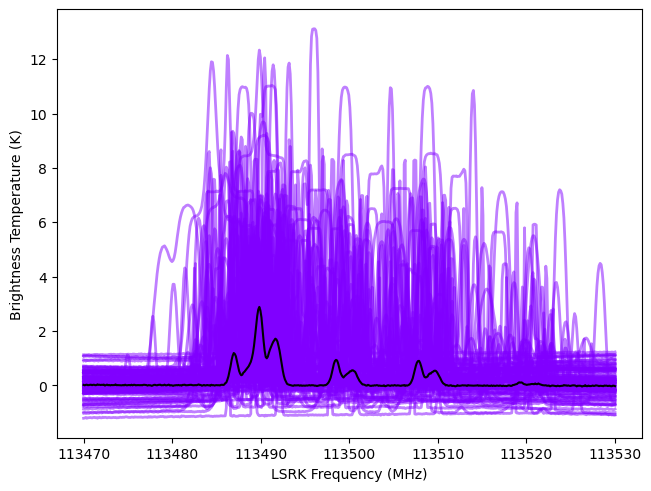

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 4600
Interrupted at 4,599 [4%]: Average Loss = 1.7162e+05


Output()

Runtime: 0.46 minutes


In [11]:
pm.summary(model.trace.posterior, var_names=model.cloud_deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],13.970,0.002,13.966,13.975,0.000,0.000,860.0,827.0,NaN
log10_N[1],14.110,0.002,14.107,14.113,0.000,0.000,1004.0,911.0,NaN
log10_N[2],13.774,0.005,13.763,13.782,0.000,0.000,1017.0,915.0,NaN
log10_tex[0],0.986,0.012,0.966,1.010,0.000,0.000,926.0,1009.0,NaN
log10_tex[1],1.088,0.005,1.078,1.098,0.000,0.000,942.0,955.0,NaN
log10_tex[2],0.943,0.033,0.884,1.007,0.001,0.001,982.0,803.0,NaN
fwhm[0],3.210,0.015,3.184,3.240,0.000,0.000,953.0,1024.0,NaN
fwhm[1],2.307,0.008,2.291,2.321,0.000,0.000,935.0,802.0,NaN
fwhm[2],5.032,0.064,4.904,5.144,0.002,0.002,803.0,874.0,NaN
velocity[0],-1.902,0.011,-1.921,-1.881,0.000,0.000,899.0,944.0,NaN


Sampling: [observation]


Output()

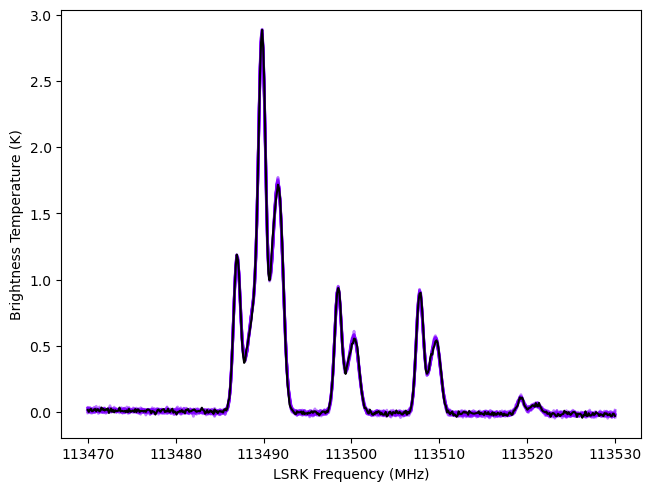

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.9}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4600
Interrupted at 4,599 [4%]: Average Loss = 1.7162e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N_norm, log10_tex_norm, fwhm_norm, velocity_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 482 seconds.


Adding log-likelihood to trace


Output()

Runtime: 8.72 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"], var_names=model.cloud_deterministics)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log10_N[0],13.996,0.009,13.981,14.013,0.000,0.000,2499.0,2995.0,1.0
log10_N[1],14.202,0.003,14.197,14.208,0.000,0.000,4797.0,5007.0,1.0
log10_N[2],13.477,0.048,13.386,13.566,0.001,0.001,2670.0,3594.0,1.0
log10_tex[0],1.000,0.013,0.975,1.025,0.000,0.000,6925.0,5820.0,1.0
log10_tex[1],1.106,0.008,1.090,1.122,0.000,0.000,5243.0,4924.0,1.0
log10_tex[2],1.112,0.077,0.967,1.255,0.001,0.001,4837.0,4551.0,1.0
fwhm[0],2.956,0.036,2.889,3.024,0.001,0.000,2695.0,3543.0,1.0
fwhm[1],2.500,0.008,2.485,2.514,0.000,0.000,4876.0,5371.0,1.0
fwhm[2],1.978,0.060,1.866,2.091,0.001,0.001,2707.0,3499.0,1.0
velocity[0],-2.015,0.027,-2.065,-1.964,0.001,0.000,2581.0,3137.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

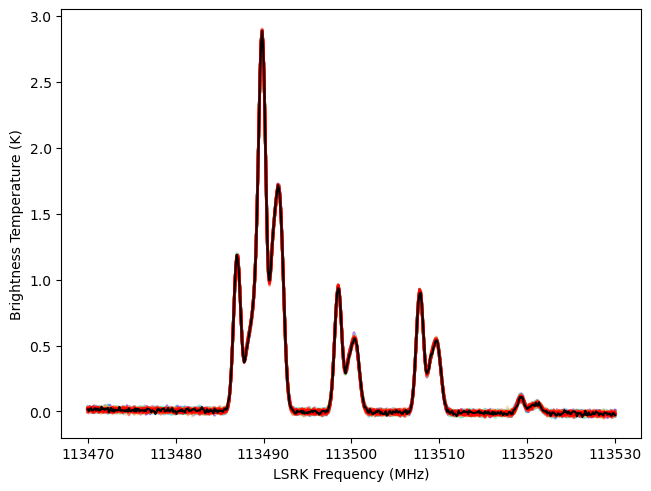

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

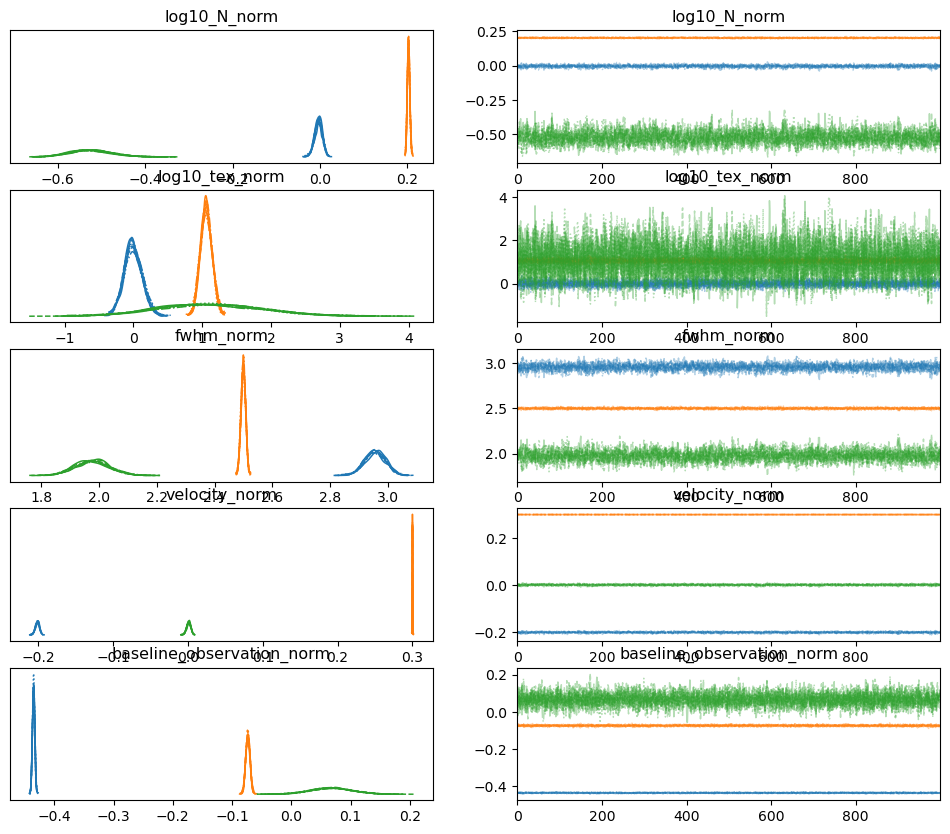

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

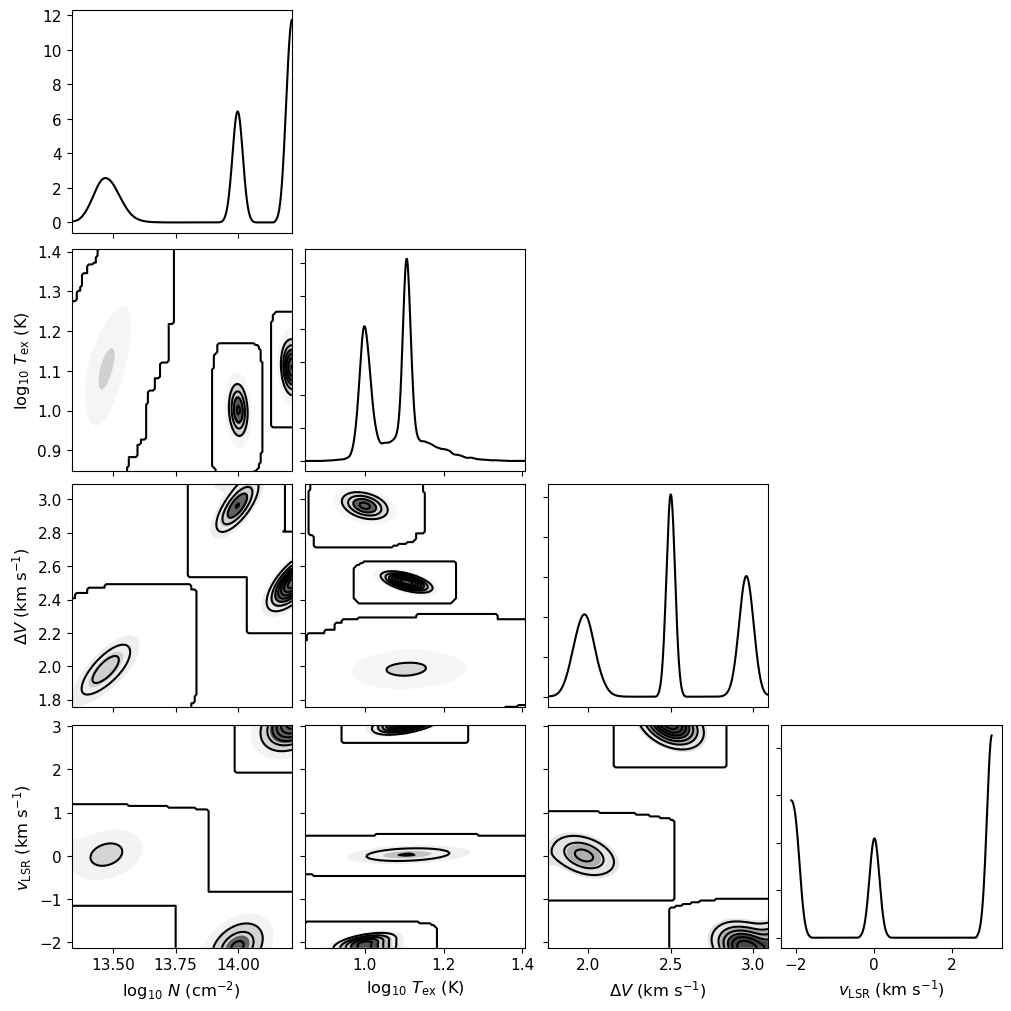

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the spectral rms hyper parameter).

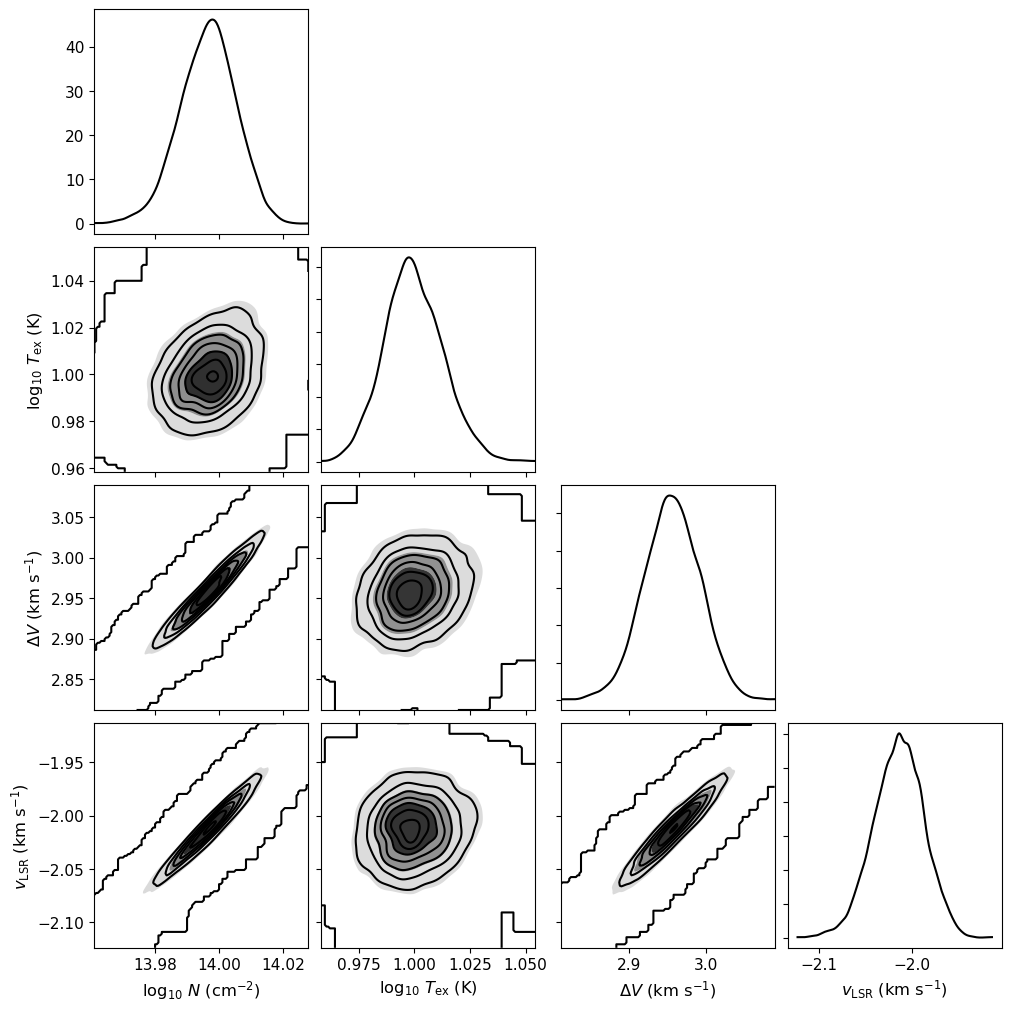

In [19]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [20]:
point_stats = az.summary(model.trace.solution_0, var_names=model.cloud_deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -3101.7835543383326


,mean,sd,hdi_16%,hdi_84%
log10_N[0],13.996,0.009,13.988,14.005
log10_N[1],14.202,0.003,14.200,14.205
log10_N[2],13.477,0.048,13.421,13.516
log10_tex[0],1.000,0.013,0.986,1.012
log10_tex[1],1.106,0.008,1.097,1.114
log10_tex[2],1.112,0.077,1.028,1.181
fwhm[0],2.956,0.036,2.921,2.993
fwhm[1],2.500,0.008,2.493,2.508
fwhm[2],1.978,0.060,1.911,2.029
velocity[0],-2.015,0.027,-2.038,-1.985
